In [1]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.optim as optim

In [2]:
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights

In [3]:
!wget -O carpet.tar.xz "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz"

!mkdir -p mvtec/
!tar -xf carpet.tar.xz -C mvtec/
base_path = "mvtec/carpet/"

--2025-07-11 14:16:54--  https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 740285760 (706M) [application/x-xz]
Saving to: ‘carpet.tar.xz’

carpet.tar.xz       100%[===================>] 705.99M  24.2MB/s    in 30s     

2025-07-11 14:17:26 (23.7 MB/s) - ‘carpet.tar.xz’ saved [740285760/740285760]



ResNet50 has fewer matrix multiplications and is highly optimized for cpu
This probably needs GPU

In [5]:
# Load ViT base model with pretrained weights
# vit_model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1).cuda()
vit_model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
vit_model.eval()

# Freeze parameters
for param in vit_model.parameters():
    param.requires_grad = False


In [7]:
transform = ViT_B_16_Weights.IMAGENET1K_V1.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [22]:
sample_path = base_path + 'train/' + 'good/' + '000.png'
sample_image = Image.open(sample_path)
sample_tensor = transform(sample_image).unsqueeze(0)
x = vit_model._process_input(sample_tensor)
print(x.shape, x[0].shape)

torch.Size([1, 196, 768]) torch.Size([196, 768])


In [23]:
print(f"Patch size is 16x16, so {224*224/(16*16)} total patches, each is represented by a 768 size vector")

Patch size is 16x16, so 196.0 total patches, each is represented by a 768 size vector


In [25]:
# class token is shared across a batch so we do this, its a learable (1,1,768) parameter
cls_token = vit_model.class_token.expand(x.shape[0], -1, -1)

In [27]:
cls_token.shape

torch.Size([1, 1, 768])

In [28]:
x = torch.cat((cls_token, x), dim=1)
print(x.shape)
x = vit_model.encoder(x)
print(x.shape)
cls_embedding = x[:, 0]
print(cls_embedding.shape)
cls_np = cls_embedding.squeeze().cpu().numpy()
print(cls_np.shape) # for image classification kind of a task you would discard the rest of the patch embeddings

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 768])
(768,)


Took about 5 minutes

In [34]:
memory_bank = []

train_folder = Path(base_path) / "train" / "good"
for pth in tqdm(train_folder.iterdir(), leave=False):
    with torch.no_grad():
        img = transform(Image.open(pth)).unsqueeze(0)
        x = vit_model._process_input(img)
        cls_token = vit_model.class_token.expand(1, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = vit_model.encoder(x)
        # for now keeping only cls token, and not individual patch embeddings, that is discarding the (196,768) part of the image, next try will some of them too.
        cls_np = x[:, 0].squeeze().cpu().numpy()
        memory_bank.append(cls_np)

memory_bank = np.array(memory_bank)

0it [00:00, ?it/s]

Took about 5 minutes

In [35]:
query_features = []
y_true = []
class_labels = []

for class_type in ['color', 'good', 'cut', 'hole', 'metal_contamination', 'thread']:
    test_folder = Path(base_path) / "test" / class_type
    for pth in tqdm(test_folder.iterdir(), leave=False):
        with torch.no_grad():
            img = transform(Image.open(pth)).unsqueeze(0)
            x = vit_model._process_input(img)
            cls_token = vit_model.class_token.expand(1, -1, -1)
            x = torch.cat((cls_token, x), dim=1)
            x = vit_model.encoder(x)
            cls_np = x[:, 0].squeeze().cpu().numpy()

        query_features.append(cls_np)
        y_true.append(0 if class_type == "good" else 1)
        class_labels.append(class_type)



0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [36]:
print(len(memory_bank))
print(len(query_features))
print(len(y_true))

280
117
117


In [39]:
print(memory_bank[0].shape)
print(query_features[0].shape)

(768,)
(768,)


Query features shape  (117, 768)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


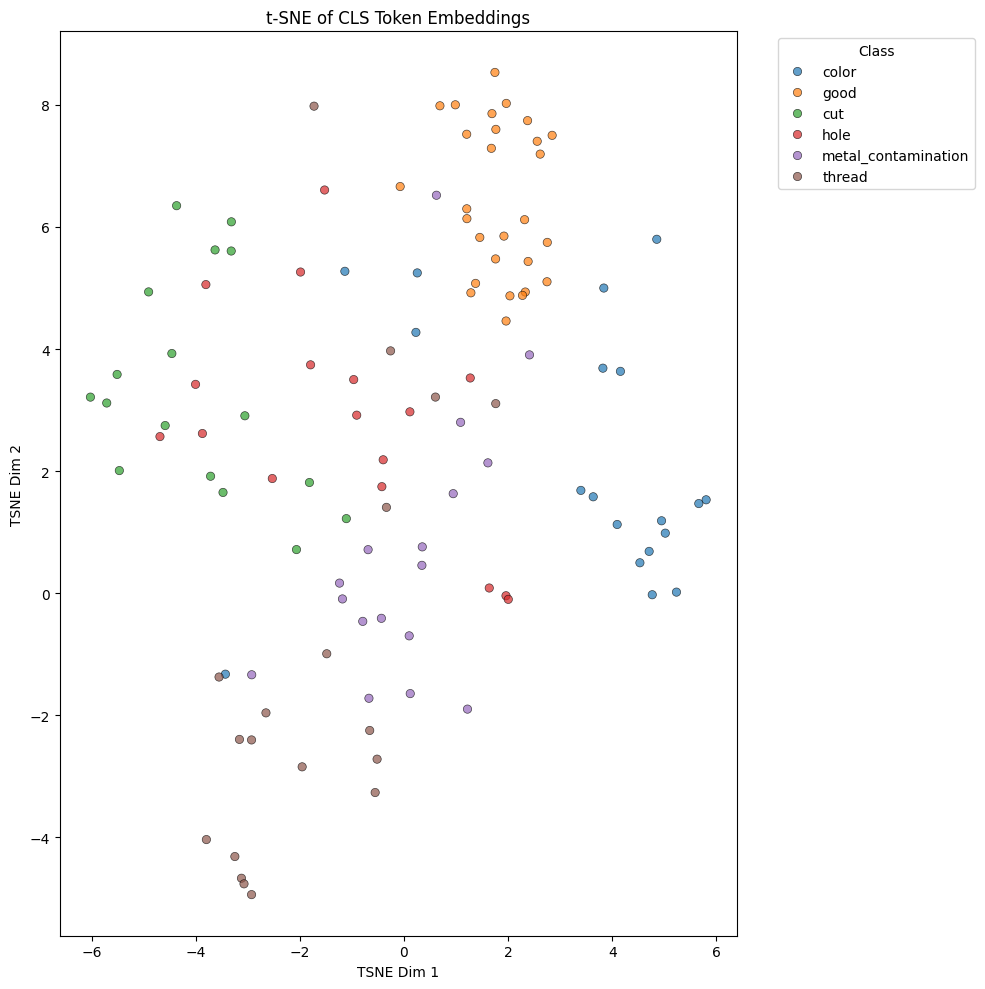

In [40]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

query_features_np = np.array(query_features)  # shape: [num_samples, 768]
print("Query features shape ",query_features_np.shape)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
query_tsne_2d = tsne.fit_transform(query_features_np)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=query_tsne_2d[:, 0],
                y=query_tsne_2d[:, 1],
                hue=class_labels,
                palette='tab10',
                alpha=0.7,
                edgecolor='k')
plt.title("t-SNE of CLS Token Embeddings")
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


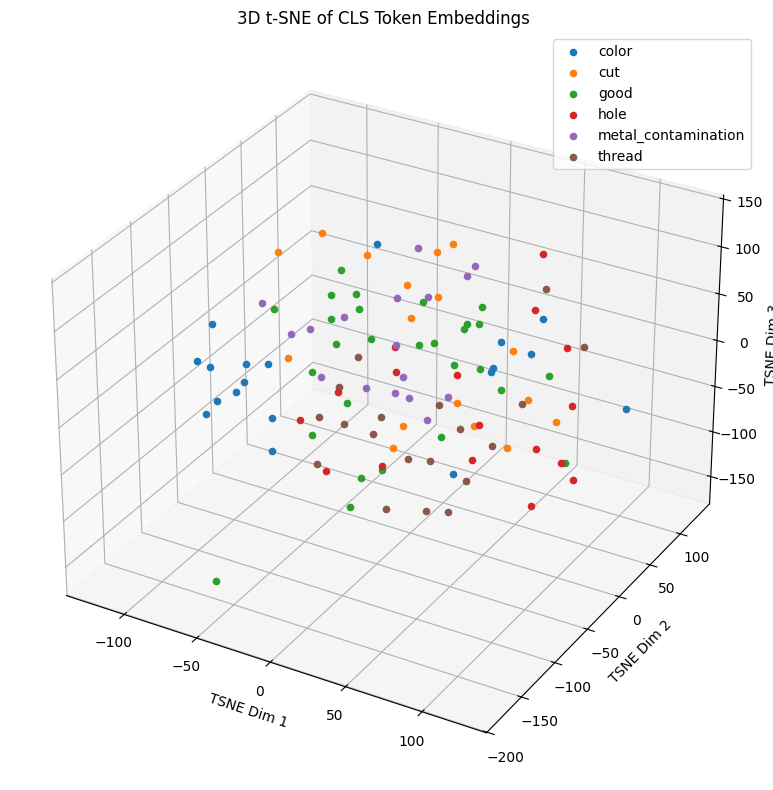

In [41]:
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
query_tsne_3d = tsne_3d.fit_transform(query_features_np)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

unique_labels = list(sorted(set(class_labels)))
palette = sns.color_palette('tab10', n_colors=len(unique_labels))
label_to_color = {label: palette[i] for i, label in enumerate(unique_labels)}

for i in range(len(query_tsne_3d)):
    label = class_labels[i]
    ax.scatter(query_tsne_3d[i, 0], query_tsne_3d[i, 1], query_tsne_3d[i, 2],
               color=label_to_color[label], label=label if label not in label_to_color else "")

for label, color in label_to_color.items():
    ax.scatter([], [], [], color=color, label=label)

ax.set_title("3D t-SNE of CLS Token Embeddings")
ax.set_xlabel("TSNE Dim 1")
ax.set_ylabel("TSNE Dim 2")
ax.set_zlabel("TSNE Dim 3")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

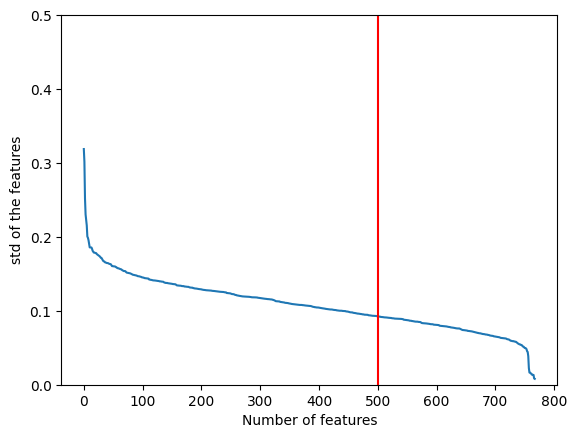

In [44]:
memory_bank_tensor = torch.tensor(np.array(memory_bank), dtype=torch.float32)  # shape: [N, 768]
values,indices = torch.sort(memory_bank_tensor.std(dim=0))

plt.plot(values.cpu().numpy()[::-1])
plt.vlines(x=500,ymin=0,ymax=0.5,colors='red')
plt.ylim([0,0.5])
plt.ylabel("std of the features")
plt.xlabel("Number of features")
plt.show()

In [45]:
memory_bank_tensor.shape

torch.Size([280, 768])

In [48]:
sample_image = transform(Image.open(Path(base_path)/"train"/"good"/"001.png")).unsqueeze(0)
x = vit_model._process_input(sample_image)
cls_token = vit_model.class_token.expand(1, -1, -1)
print(x.shape)
x = torch.cat((cls_token, x), dim=1)
print(x.shape)
x = vit_model.encoder(x)
print(x.shape)
cls_embedding = x[:, 0]
print(cls_embedding.shape)
dists = torch.norm(memory_bank_tensor - cls_embedding, dim=1)
print("shape of dists: ", dists.shape)

torch.Size([1, 196, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 768])
shape of dists:  torch.Size([280])


In [50]:
dists[:5]

tensor([5.7050, 5.8504, 6.4416, 5.1041, 5.2868])

took 5 minutes

In [51]:
# --- Compute k-NN anomaly score on 'good' samples ---
y_score = []
k = 50

for pth in tqdm(train_folder.iterdir(), desc="Computing kNN Scores"):
    with torch.no_grad():
        img = transform(Image.open(pth)).unsqueeze(0)
        x = vit_model._process_input(img)
        cls_token = vit_model.class_token.expand(1, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = vit_model.encoder(x)
        cls_embedding = x[:, 0]  # [1, 768]

        dists = torch.norm(memory_bank_tensor - cls_embedding, dim=1)
        topk_dist = torch.sort(dists)[0][:k].mean()
        y_score.append(topk_dist.cpu().item())

Computing kNN Scores: 0it [00:00, ?it/s]

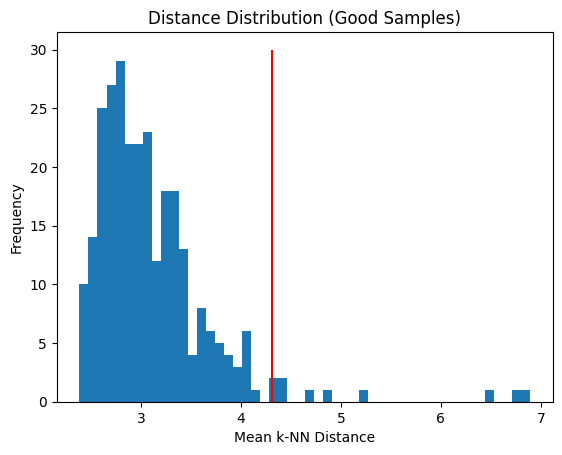

In [52]:
y_score = np.array(y_score)
best_threshold = y_score.mean() + 2 * y_score.std()

plt.hist(y_score, bins=50)
plt.vlines(x=best_threshold, ymin=0, ymax=30, color='r')
plt.title("Distance Distribution (Good Samples)")
plt.xlabel("Mean k-NN Distance")
plt.ylabel("Frequency")
plt.show()

In [53]:
print(f"Best threshold is {best_threshold}")

Best threshold is 4.312173878012495


/tmp/ipython-input-55-524998014.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_features = torch.tensor(query_features).to(device)  # Shape [M, 768]


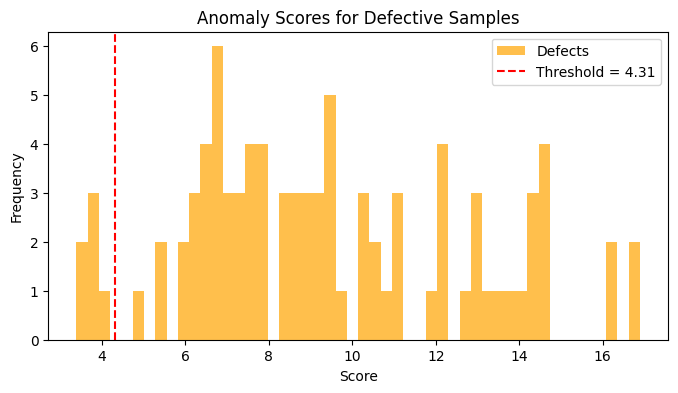

In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report

k = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

query_features = torch.tensor(query_features).to(device)  # Shape [M, 768]

y_score = []

for q_feat in query_features:
    with torch.no_grad():
        dist = torch.norm(memory_bank_tensor - q_feat, dim=1)
        mean_dist = dist.topk(k, largest=False).values.mean()
        y_score.append(mean_dist.item())

y_score = np.array(y_score)
y_true = np.array(y_true)
class_labels = np.array(class_labels)

good_scores = y_score[y_true == 0]

y_pred = (y_score > best_threshold).astype(int)

plt.figure(figsize=(8, 4))
plt.hist(y_score[y_true == 1], bins=50, alpha=0.7, color='orange', label='Defects')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Threshold = {best_threshold:.2f}')
plt.title("Anomaly Scores for Defective Samples")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()



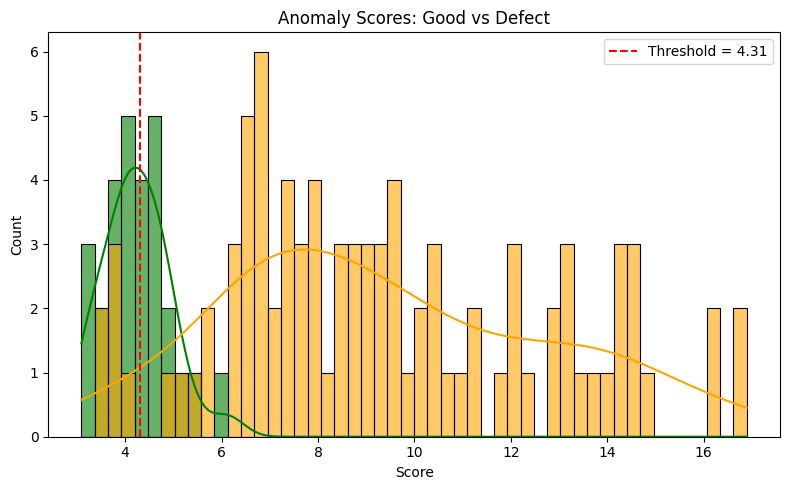

/tmp/ipython-input-56-1483201970.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Label", y="Score", palette="Set2")


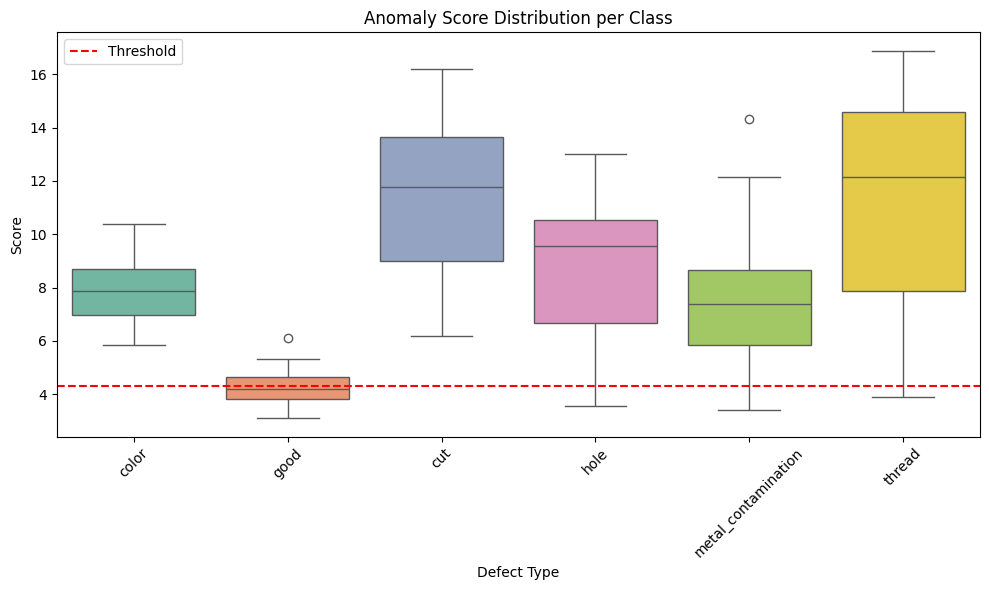

In [56]:
import pandas as pd
df = pd.DataFrame({
    "Score": y_score,
    "Label": class_labels,
    "Type": ["Good" if y == 0 else "Defect" for y in y_true]
})

plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="Score", hue="Type", bins=50, kde=True,
             palette={"Good": "green", "Defect": "orange"}, alpha=0.6)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Threshold = {best_threshold:.2f}')
plt.title("Anomaly Scores: Good vs Defect")
plt.xlabel("Score")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Label", y="Score", palette="Set2")
plt.axhline(best_threshold, color='red', linestyle='--', label='Threshold')
plt.title("Anomaly Score Distribution per Class")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.xlabel("Defect Type")
plt.legend()
plt.tight_layout()
plt.show()

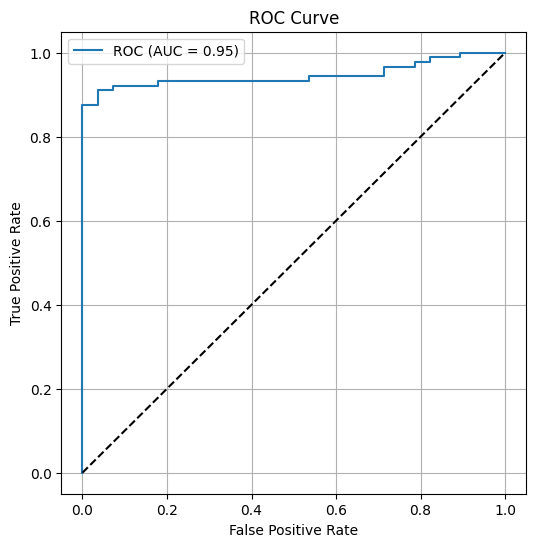

In [57]:
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


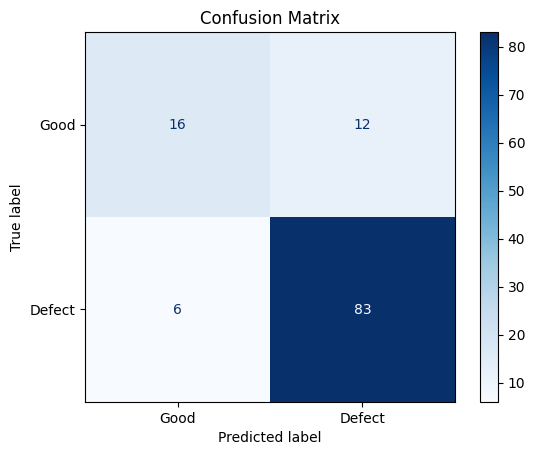

              precision    recall  f1-score   support

        Good       0.73      0.57      0.64        28
      Defect       0.87      0.93      0.90        89

    accuracy                           0.85       117
   macro avg       0.80      0.75      0.77       117
weighted avg       0.84      0.85      0.84       117



In [58]:

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good", "Defect"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# --- Classification Report ---
print(classification_report(y_true, y_pred, target_names=["Good", "Defect"]))

Got an ROC AUC of 0.95 without the patch embeddings and just the cls_label embeddings!